In [1]:
%load_ext Cython

## Transit Intensity Vector Functions

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import interpolate
import math

def gen_lin_ptv(public_trans=1, days=100, earlier_start=0, earlier_decline=0, earlier_bottom=0, low_val=0.07, reopen_day=88, reopen_val=0.07, scenario=1):
    '''
    Function to generate transit intensity vector as a piecewise linear function, with user-specified conditions.
    
    Parameters
    ----------
    public_trans (float): 
        Baseline % of population using public transit before the pandemic. Defaults to 1.
    days (int):
        Number of days to run simulation for. Defaults to 100.
    earlier_start (int): 
        Number of days prior to Feb 22nd to begin the simulation. This allows for the possibility of infections to have been introduced earlier than 
        what is known. Feb 22nd is 5 days before the first confirmed patient's symptoms began--the estimated date of their infection. Defaults to 0.
    earlier_decline (int): 
        Number of days prior to March 7th to set for the start of transit-decline. March 7th is when a state of emergency was declared in NY. Defaults to 0.
    earlier_bottom (int): 
        Number of days prior to April 8th to set for the minimum transit intensity. On April 8th the MTA reported that ridership had fallen by 93%.
        This controls the steepness of the decline. Defaults to 0.
    low_val (float):
        The lowest percentage of typical ridership to decrease transit values to. Defaults to 0.07, as reported by the MTA.
    reopen_day (int):
        The day to designate for transit beginning to increase. Defaults to 88--which corresponds to May 15th--the day that the current travel restrictions will expire. 
    reopen_val (float):
        The value to increase transit intensity to when travel restrictions end. Defaults to 0.07, which represents transit restrictions being renewed.
    scenario (int):
        Value to indicate different sets of conditions for generating the transit values. Value of '1' generates values in which transit stays constant, 
        '2' generates declining transit values, and '3' generates values that decline and eventually increase. Defaults to 1. 
        
    Returns
    ----------
    public_trans_vec (ndarray of np.float64): 
        Vector of transit intensity values rounded to 2 decimal places.
    '''  
    
    # scenario 1: constant transit
    if scenario == 1:
        public_trans_vec = np.full(days, public_trans)
    
    # scenario 2: transit decreases and stays low
    elif scenario == 2:
        low_val *= public_trans
        x = [19+earlier_start-earlier_decline, 29+earlier_start-earlier_decline, 51-earlier_bottom+earlier_start-earlier_decline]
        y = [1, .4, low_val]
        f = interpolate.interp1d(x, y)
        # append values for days before and after periods of decreasing ridership
        ridership = np.append(np.ones(18+earlier_start-earlier_decline), f(np.arange(19+earlier_start-earlier_decline,52-earlier_bottom+earlier_start-earlier_decline)))
        ridership = np.append(ridership, np.full(days-len(ridership), low_val))
        # multiply ridership by public_trans to get public_trans_vec, append to reopen_vals
        public_trans_vec = ridership * public_trans
          
    # scenario 3: transit decreases and then increases
    elif scenario == 3:
        x = [19+earlier_start-earlier_decline, 29+earlier_start-earlier_decline, 51+earlier_start-earlier_decline, 60+earlier_start-earlier_decline]
        y = [public_trans, public_trans*.4, public_trans*.08, public_trans*low_val]
        f = interpolate.interp1d(x, y)
        # append values for days before and after periods of decreasing ridership
        ridership = np.append(public_trans*np.ones(18+earlier_start-earlier_decline), f(np.arange(19+earlier_start-earlier_decline,61+earlier_start-earlier_decline)))
        ridership = np.append(ridership, np.full(days-len(ridership), reopen_val))
        public_trans_vec = ridership
    
    return np.around(public_trans_vec, 2)


def gen_log_ptv(days=100, k=.4, start_ptv=1, inflection=28, min_ptv=0.07, reopen=False, reopen_day=88, reopen_val=.5, plot=False):
    '''
    Function to generate transit intensity vector with a logistic function, with user-specified conditions.

    Parameters
    ----------
    days (int):
        Number of days to run simulation for. Defaults to 100.
    k (float): 
        Steepness of curve. Value must be in the range [0,1]. Defaults to .4.
    start_ptv (float): 
        Baseline % of population using public transit before the pandemic. Defaults to 1.
    inflection (int): 
        X-value corresponding to the steepest slope of the logistic function. Making this value lower or higher shifts the curve left or right. Defaults to 28.
    min_ptv (float):
        The lowest percentage of typical ridership to decrease transit values to. Defaults to 0.07, as reported by the MTA.
    reopen (bool):
        Boolean determining whether to increase values on the reopen_day. Defaults to False.
    reopen_day (int):
        The day to designate for transit beginning to increase. Defaults to 88--which corresponds to May 15th--the day that the current travel restrictions will expire. 
    reopen_val (float):
        The value to increase transit intensity to when travel restrictions end. Defaults to 0.5 of start_ptv.
    plot (bool):
        Boolean determining whether to plot the transit intensity curve. Defaults to False.

    Returns
    ----------
    log_ptv (ndarray of np.float64): 
        Vector of transit intensity values rounded to 2 decimal places.
    '''  
    min_ptv = min_ptv*start_ptv
    log_ptv = [(start_ptv-min_ptv) / (1 + np.exp(-k*(-t+inflection))) + min_ptv for t in range(days)]
    if reopen:
        for i in range(reopen_day,days):
            log_ptv[i] = reopen_val*start_ptv
    if plot:
        fig = plt.figure()
        ax = plt.axes()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.plot(np.arange(days), log_ptv, '--', label=f'k={k}', color='k', linewidth=2)
        ax.legend(frameon=False, loc='center left', bbox_to_anchor=(1.01, 0.5))
        ax.set_xlabel("Days")
        ax.set_ylabel("transit")
        plt.show()
    return np.around(log_ptv, 2)

## Simulation Code

In [5]:
%%cython

# cython: profile=True
# cython: linetrace=True
# cython: binding=True
# distutils: define_macros=CYTHON_TRACE_NOGIL=1

import numpy as np
from tqdm import tqdm
import argparse
from multiprocessing import cpu_count
from functools import partial
from multiprocessing.pool import Pool
import pandas as pd
cimport numpy as np
from scipy import interpolate
import math

def gen_log_ptv(days=100, k=.4, start_ptv=1, inflection=28, min_ptv=0.07, reopen=False, reopen_day=88, reopen_val=.5, plot=False):
    '''
    Function to generate transit intensity vector with a logistic function, with user-specified conditions.

    Parameters
    ----------
    days (int):
        Number of days to run simulation for. Defaults to 100.
    k (float): 
        Steepness of curve. Value must be in the range [0,1]. Defaults to .4.
    start_ptv (float): 
        Baseline % of population using public transit before the pandemic. Defaults to 1.
    inflection (int): 
        X-value corresponding to the steepest slope of the logistic function. Making this value lower or higher shifts the curve left or right. Defaults to 28.
    min_ptv (float):
        The lowest percentage of typical ridership to decrease transit values to. Defaults to 0.07, as reported by the MTA.
    reopen (bool):
        Boolean determining whether to increase values on the reopen_day. Defaults to False.
    reopen_day (int):
        The day to designate for transit beginning to increase. Defaults to 88--which corresponds to May 15th--the day that the current travel restrictions will expire. 
    reopen_val (float):
        The value to increase transit intensity to when travel restrictions end. Defaults to 0.5 of start_ptv.
    plot (bool):
        Boolean determining whether to plot the transit intensity curve. Defaults to False.

    Returns
    ----------
    log_ptv (ndarray of np.float64): 
        Vector of transit intensity values rounded to 2 decimal places.
    '''  
    min_ptv = min_ptv*start_ptv
    log_ptv = [(start_ptv-min_ptv) / (1 + np.exp(-k*(-t+inflection))) + min_ptv for t in range(days)]
    if reopen:
        for i in range(reopen_day,days):
            log_ptv[i] = reopen_val*start_ptv
    if plot:
        import matplotlib.pyplot as plt
        fig = plt.figure()
        ax = plt.axes()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.plot(np.arange(days), log_ptv, '--', label=f'k={k}', color='k', linewidth=2)
        ax.legend(frameon=False, loc='center left', bbox_to_anchor=(1.01, 0.5))
        ax.set_xlabel("Days")
        ax.set_ylabel("transit")
        plt.show()
    return np.around(log_ptv, 2)

def graphing_function(np.ndarray[np.float64_t, ndim=1] infected_pop_norm, 
                      np.ndarray[np.float64_t, ndim=1] susceptible_pop_norm, 
                      np.ndarray[np.float64_t, ndim=1] recovered_pop_norm, 
                      np.ndarray[np.float64_t, ndim=1] public_trans_vec, 
                      int days, 
                      fig_name,
                      plot_title):
    import matplotlib.pyplot as plt
    # plot results and save the plot
    fig = plt.figure()
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.plot(np.arange(days), susceptible_pop_norm, label='Susceptible', color='#4aa5f0', linewidth=2)
    ax.plot(np.arange(days), infected_pop_norm, label='Infected', color='#f03737', linewidth=2)
    ax.plot(np.arange(days), recovered_pop_norm, label='Recovered', color='#82e88a', linewidth=2)
    ax.plot(np.arange(days), public_trans_vec, '--', label='Transit Intensity', color='k', linewidth=2)
    ax.legend(frameon=False, loc='center left', bbox_to_anchor=(1.01, 0.5))
    ax.set_xlabel("Days")
    ax.set_ylabel("Share of Population")
    plot_title = plot_title.replace('_',' ').replace('[','').replace(']','').replace("'",'')
    plt.title(plot_title)
    if fig_name:
        ax.figure.savefig('figures/' + fig_name + '.png')
    else:
        ax.figure.savefig('figures/sir_plot.png')
    plt.show()
    plt.close()
    
    
# Convenience function: access Python dict keys as dict.key instead of dict['key']
class objdict(dict):
    def __getattr__(self, name):
        if name in self:
            return self[name]
        else:
            raise AttributeError("No such attribute: " + name)

    def __setattr__(self, name, value):
        self[name] = value

    def __delattr__(self, name):
        if name in self:
            del self[name]
        else:
            raise AttributeError("No such attribute: " + name)
            
# Run n simulations in parallel: for each run, parameters are randomly sampled from an interval
# NOTE: Are these intervals reasonable?
def multiprocess(args):

    chunks = []
    num_procs = args.randomize
    for _ in range(num_procs):
        d = dict()
        d['origin_matrix_path'] = args.origin_matrix_path
        d['thresh1'] = np.random.randint(0, 350)
        d['thresh2'] = np.random.randint(d['thresh1'], 700)
        d['infect_pct'] = float(args.infect_pct)
        d['beta'] = args.beta
        d['gamma'] = args.gamma
        d['public_trans'] = args.public_trans
        d['public_trans_vec'] = np.asarray([float(i.replace('[', '').replace(',','').replace(']','')) for i in args.public_trans_vec])
        d['days'] = args.days
        d['fig_name'] = 'public_trans_{:0.1f}_({}, {})_inf_{}'.format(d['public_trans'], d['thresh1'], d['thresh2'], d['infection_magnitude'])
        d['plot_title'] = args.plot_title
        d['loading'] = args.loading
        d = objdict(d)
        chunks.append(d)

    with Pool(num_procs) as p:
        p.map(covid_mp_sim, chunks)

    p.join()

def covid_sim(args):
    # Read in origin-destination flow matrix  
    cdef np.ndarray[np.float64_t, ndim=2] OD, SIR, SIR_n, SIR_sim, SIR_nsim, infected_mat, OD_infected 
    cdef np.ndarray[np.float64_t, ndim=1] N_k, first_infections, row_sums, beta_vec, gamma_vec, inflow_infected, new_infect, new_recovered
    cdef int locs_len, time_step
    cdef np.float64_t R0, S, I, R
    cdef np.ndarray[np.float64_t, ndim=1] infected_pop_norm, susceptible_pop_norm, recovered_pop_norm

    if args.loading != 0:
        OD = pd.read_csv('data/nyc_od.csv', header=None, dtype=np.float64).to_numpy()
    else:
        OD = np.genfromtxt(args.origin_matrix_path, delimiter=',')

    # initialize the population vector from the origin-destination flow matrix
    N_k = np.abs(np.diagonal(OD) + OD.sum(axis=0) - OD.sum(axis=1))
    locs_len = len(N_k)                 # number of locations
    SIR = np.zeros(shape=(locs_len, 3)) # make a numpy array with 3 columns for keeping track of the S, I, R groups
    SIR[:,0] = N_k                      # initialize the S group with the respective populations
    thresh1 = args.thresh1
    thresh2 = args.thresh2
    first_infections = np.where((thresh1 <= SIR[:, 0]) & (SIR[:, 0] <= thresh2), np.floor(args.infect_pct*SIR[:,0]), 0).astype(np.float64)
    SIR[:, 0] = SIR[:, 0] - first_infections                           # remove infections from S group
    SIR[:, 1] = SIR[:, 1] + first_infections                           # move infections to the I group
    
    print(f'Initial Infected: {int(np.sum(first_infections)*1.062972)}')
    
    # row normalize the SIR matrix for keeping track of group proportions
    row_sums = SIR.sum(axis=1)
    SIR_n = SIR / row_sums[:, np.newaxis]

    # initialize parameters
    days = args.days
    beta = args.beta
    gamma = args.gamma
    public_trans = args.public_trans                                 # alpha
    R0 = beta/gamma
    beta_vec = np.random.gamma(beta*.5, 2, locs_len)
    gamma_vec = np.full(locs_len, gamma)
#     public_trans_vec = args.public_trans_vec
    # convert public_trans_vec to floats if needed
#     if isinstance(public_trans_vec[0], str):
#         public_trans_vec = np.asarray([float(i.replace('[', '').replace(',','').replace(']','')) for i in public_trans_vec])
    public_trans_vec = gen_log_ptv(days=days, k=args.k, start_ptv=public_trans, inflection=args.inflection, min_ptv=args.min_ptv, 
                                   reopen=args.reopen, reopen_day=args.reopen_day, reopen_val=args.reopen_val, plot=args.plot_ptv)
    fig_name = args.fig_name
    plot_title = str(args.plot_title)
    
    # make copy of the SIR matrices 
    SIR_sim = SIR.copy()
    SIR_nsim = SIR_n.copy()

    # run model
    infected_pop_norm = np.zeros(days)
    susceptible_pop_norm = np.zeros(days)
    recovered_pop_norm = np.zeros(days)
    for time_step in range(days):
        infected_mat = np.array([SIR_nsim[:,1],]*locs_len).transpose()
        OD_infected = np.round(OD*infected_mat)
        inflow_infected = OD_infected.sum(axis=0)
        inflow_infected = np.round(inflow_infected*public_trans_vec[time_step])
        new_infect = beta_vec*SIR_sim[:, 0]*inflow_infected/(N_k + OD.sum(axis=0))
        new_recovered = gamma_vec*SIR_sim[:, 1]
        new_infect = np.where(new_infect>SIR_sim[:, 0], SIR_sim[:, 0], new_infect)
        SIR_sim[:, 0] = SIR_sim[:, 0] - new_infect
        SIR_sim[:, 1] = SIR_sim[:, 1] + new_infect - new_recovered
        SIR_sim[:, 2] = SIR_sim[:, 2] + new_recovered
        SIR_sim = np.where(SIR_sim<0,0,SIR_sim)
        # recompute the normalized SIR matrix
        row_sums = SIR_sim.sum(axis=1)
        SIR_nsim = SIR_sim / row_sums[:, np.newaxis]
        S = SIR_sim[:,0].sum()/N_k.sum()
        I = SIR_sim[:,1].sum()/N_k.sum()
        R = SIR_sim[:,2].sum()/N_k.sum()
        # update pop_norm vectors with new values
        infected_pop_norm[time_step] = I 
        susceptible_pop_norm[time_step] = S 
        recovered_pop_norm[time_step] = R
    print(f'Total Infected: {round(recovered_pop_norm[99],4)}')
    graphing_function(infected_pop_norm, susceptible_pop_norm, recovered_pop_norm, public_trans_vec, days, fig_name, plot_title)
    
def covid_mp_sim(args):
    # Read in origin-destination flow matrix  
    cdef np.ndarray[np.float64_t, ndim=2] OD, SIR, SIR_n, SIR_sim, SIR_nsim, infected_mat, OD_infected 
    cdef np.ndarray[np.float64_t, ndim=1] N_k, first_infections, row_sums, beta_vec, gamma_vec, inflow_infected, new_infect, new_recovered, public_trans_vec
    cdef int locs_len, time_step
    cdef np.float64_t R0, S, I, R
    cdef np.ndarray[np.float64_t, ndim=1] infected_pop_norm, susceptible_pop_norm, recovered_pop_norm 

    if args.loading != 0:
        OD = pd.read_csv('data/nyc_OD.csv', header=None, dtype=np.float64).to_numpy()
    else:
        OD = np.genfromtxt(args.origin_matrix_path, delimiter=',')

    # initialize the population vector from the origin-destination flow matrix
    N_k = np.abs(np.diagonal(OD) + OD.sum(axis=0) - OD.sum(axis=1))
    locs_len = len(N_k)                 # number of locations
    SIR = np.zeros(shape=(locs_len, 3)) # make a numpy array with 3 columns for keeping track of the S, I, R groups
    SIR[:,0] = N_k                      # initialize the S group with the respective populations
    thresh1 = args.thresh1
    thresh2 = args.thresh2
    first_infections = np.where((thresh1 <= SIR[:, 0]) & (SIR[:, 0] <= thresh2), np.floor(args.infect_pct*SIR[:,0]), 0).astype(np.float64)
    SIR[:, 0] = SIR[:, 0] - first_infections
    SIR[:, 1] = SIR[:, 1] + first_infections                           # move infections to the I group
    
    # row normalize the SIR matrix for keeping track of group proportions
    row_sums = SIR.sum(axis=1)
    SIR_n = SIR / row_sums[:, np.newaxis]

    # initialize parameters
    beta = args.beta
    gamma = args.gamma
    public_trans = args.public_trans                                 # alpha
    R0 = beta/gamma
    beta_vec = np.random.gamma(beta, 2, locs_len)
    gamma_vec = np.full(locs_len, gamma)
    public_trans_vec = args.public_trans_vec
#     if isinstance(public_trans_vec[0], str):
#         public_trans_vec = np.asarray([float(i.replace('[', '').replace(',','').replace(']','')) for i in public_trans_vec])
    fig_name = args.fig_name
    plot_title = args.plot_title

    # make copy of the SIR matrices 
    SIR_sim = SIR.copy()
    SIR_nsim = SIR_n.copy()

    # run model
    #print(SIR_sim.sum(axis=0).sum() == N_k.sum())
    days = args.days
    infected_pop_norm = np.zeros(days)
    susceptible_pop_norm = np.zeros(days)
    recovered_pop_norm = np.zeros(days)
    for time_step in tqdm(range(days)):
        infected_mat = np.array([SIR_nsim[:,1],]*locs_len).transpose()
        OD_infected = np.round(OD*infected_mat)
        inflow_infected = OD_infected.sum(axis=0)
        inflow_infected = np.round(inflow_infected*public_trans_vec[time_step])
        #print('total infected inflow: ', inflow_infected.sum())
        new_infect = beta_vec*SIR_sim[:, 0]*inflow_infected/(N_k + OD.sum(axis=0))
        new_recovered = gamma_vec*SIR_sim[:, 1]
        new_infect = np.where(new_infect>SIR_sim[:, 0], SIR_sim[:, 0], new_infect)
        SIR_sim[:, 0] = SIR_sim[:, 0] - new_infect
        SIR_sim[:, 1] = SIR_sim[:, 1] + new_infect - new_recovered
        SIR_sim[:, 2] = SIR_sim[:, 2] + new_recovered
        SIR_sim = np.where(SIR_sim<0,0,SIR_sim)
        # recompute the normalized SIR matrix
        row_sums = SIR_sim.sum(axis=1)
        SIR_nsim = SIR_sim / row_sums[:, np.newaxis]
        S = SIR_sim[:,0].sum()/N_k.sum()
        I = SIR_sim[:,1].sum()/N_k.sum()
        R = SIR_sim[:,2].sum()/N_k.sum()
        infected_pop_norm[time_step] = I 
        susceptible_pop_norm[time_step] = S 
        recovered_pop_norm[time_step] = R
    
    graphing_function(infected_pop_norm, susceptible_pop_norm, recovered_pop_norm, public_trans_vec, days, fig_name, plot_title)

### Parser

In [6]:
parser = argparse.ArgumentParser(description='COVID Simulator')
parser.add_argument('--randomize', type=int, default=0)
parser.add_argument('--origin-matrix-path', default='data/nyc_od.csv')
parser.add_argument('--thresh1', type=int, default=0)
parser.add_argument('--thresh2', type=int, default=200)
parser.add_argument('--infect-pct', type=float, default=0.05)
parser.add_argument('--beta', type=float, default=0.75)
parser.add_argument('--gamma', type=float, default=0.2)
parser.add_argument('--public-trans', type=float, default=1)
parser.add_argument('--public-trans-vec', nargs='+', default=[])
parser.add_argument('--k', type=float, default=0.4)
parser.add_argument('--inflection', type=int, default=28)
parser.add_argument('--min-ptv', type=float, default=0.07)
parser.add_argument('--reopen', type=bool, default=False)
parser.add_argument('--reopen-day', type=int, default=88)
parser.add_argument('--reopen-val', type=int, default=88)
parser.add_argument('--plot-ptv', type=bool, default=False)
parser.add_argument('--days', type=int, default=100)
parser.add_argument('--img-folder', default='figures/')
parser.add_argument('--loading', default = 0)
parser.add_argument('--fig-name', default = 'figure_1')
parser.add_argument('--plot-title', nargs='+', type=str, default='COVID-19 Simulation')

_StoreAction(option_strings=['--plot-title'], dest='plot_title', nargs='+', const=None, default='COVID-19 Simulation', type=<class 'str'>, choices=None, help=None, metavar=None)

## Parameters

### $\beta$ (transmission rate)
The transmission rate, or effective contact rate, is the average number of people an infected individual spreads the virus to each day. As this number can vary greatly, with some individuals acting as "super spreaders" and others exhibiting very low transmission rates, this parameter is modeled with a Gamma-distributed random variable, drawn separately for different parts of the city. 

Text(0.5, 1.0, 'Distribution of beta (Mean = 0.75)')

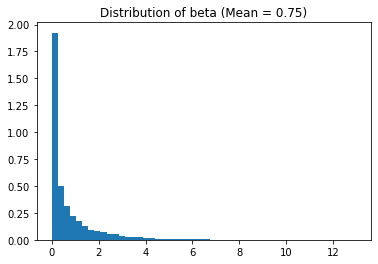

In [182]:
shape = .75/2
scale = 2
s = np.random.gamma(shape, scale, 10000)
from scipy import stats
import scipy.special as sps
count, bins, ignored = plt.hist(s, 50, density=True)
plt.title(f'Distribution of beta (Mean = {np.mean(s):.2f})')

### $\gamma^{-1}$ (infectious period)
Assumed to be 5 days, with $\gamma = 0.2$, where $\gamma$ is the recovery rate. Note that this is not the length of time from contraction of the virus until recovery. This is the effective amount of time an individual is "infectious" for. There is an initial latent period, usually for only a few days, during which an individual has the virus in their system but is not yet infectious. Additionally, if an individual is technically infectious, but is in quarantine and thus unable to spread the virus, they are not considered to be infectious. 

### $R_{0}$ (basic reproductive number)
This is the average number of people an infected individual spreads the virus to during the course of their infectious period. $R_{0} = \beta\cdot\gamma^{-1}$. This parameter incorporates both tranmission rate and recovery rate, and is the most widely reported parameter among virus transmission research. 

Text(0.5, 1.0, 'Distribution of R0 (Mean = 0.75)')

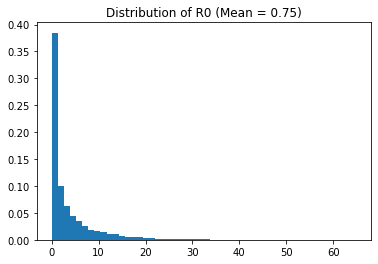

In [183]:
count, bins, ignored = plt.hist(np.divide(s,.2), 50, density=True)
plt.title(f'Distribution of R0 (Mean = {np.mean(s):.2f})')

### Modal Split/Transit Intensity

The variable 'public_trans_vec' in our simulation represents the intensity of public transportation. 56% of the population of NYC is estimated to use public transportation. Thus, we initially set public_trans to 0.56. The earliest reported symptoms of a confirmed case occurred on Feb 22nd, and we estimate that the 
individual was infected 5 days prior (Feb 17th). This will mark the first day of our simulation, although 
there were likely infections prior to this date, since the infected individual did not travel anywhere 
prior to contracting the virus. NYC limited transportation of non-essential workers on March 22nd, 34 days 
later. This is reflected by lowering the public_trans value on the 34th day of the simulation. 
Reports from the MTA have stated that from February, subway ridership fell by 60% as of 
March 17th, and 92% by April 8th, and 93% by April 17th. We can use these values to estimate public_trans 
over time. <br><br>


#### Timeline
Day &emsp; Ridership <br>
1 &emsp;&emsp;&nbsp;  100% <br>
19 &emsp;&emsp;100% (March 7th -- state of emergency declared -- this is when ridership likely started falling) <br>
29 &emsp;&emsp; 40% (March 17th) <br>
51 &emsp;&emsp; 8%  (April 8th) <br>
60 &emsp;&emsp; 7%  (April 17th) <br>
88 &emsp;&emsp; 28%  (May 15th -- possible lifting of stay-at-home restrictions) <br>
<br>
Sources: <br>
https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_New_York_(state)#Timeline <br>
https://nytransit.org/resources/public-transit-facts <br>
https://comptroller.nyc.gov/reports/new-york-citys-frontline-workers/<br>
http://web.mta.info/nyct/facts/ridership/ <br>
https://www.businessinsider.com/coronavirus-nyc-subway-ridership-craters-amid-coronavirus-mta-seeks-bailout-2020-3 <br>
https://www.businessinsider.com/new-york-subway-rides-plunge-mta-requests-second-bailout-93-2020-4 <br>
https://brooklyneagle.com/articles/2020/04/08/new-york-city-subway-ridership-down-92-percent-due-to-coronavirus/

##### MTA ridership over time

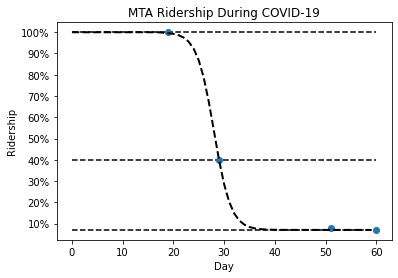

In [23]:
# approximate ridership percentages over time 
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import numpy as np
%matplotlib inline

earlier_start = 0    # days before Feb 22 (day of Patient-0's first reported symptoms)
x = [19+earlier_start, 29+earlier_start, 51+earlier_start, 60+earlier_start]
y = [1, .4, .08, .07]
f = interp1d(x, y)
plt.plot(x, y, 'o')
plt.xlabel('Day')
plt.ylabel('Ridership')
# new_y = np.append([1], f(x))
# x = np.append([1], x)
# plt.plot(x, new_y, 'g', '-')
# plt.scatter(x, y)

# logistic curve for smoothed version:
def gen_log_ptv(t, k=.4, start_ptv=1, inflection=28, end_ptv=0.07, reopen=False, reopen_val=.5):
    end_ptv *= start_ptv
    return (start_ptv-end_ptv) / (1 + np.exp(-k*(-t+inflection))) + end_ptv
t = np.linspace(19, 60, 42)
log_ptv = [gen_log_ptv(i, k=.6, start_ptv=1, inflection=10, end_ptv=0.07) for i in range(len(t))]
log_ptv = np.append(np.ones(18), log_ptv)
plt.plot(np.arange(60), log_ptv, '--', label='k=0.5', color='k', linewidth=2)
plt.yticks(np.arange(0,1.1, step=0.1), ['0','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'])
plt.hlines([1, .4, .07], 0, 60+earlier_start, linestyles='--')
plt.title('MTA Ridership During COVID-19')
plt.savefig('figures/MTA_ridership.png')
plt.show()

# Experiments

### Experiment 1: effect of travel intensity for diff constant levels

Initial Infected: 290
Infected on March 1st: 0
Total Infected: 0.259


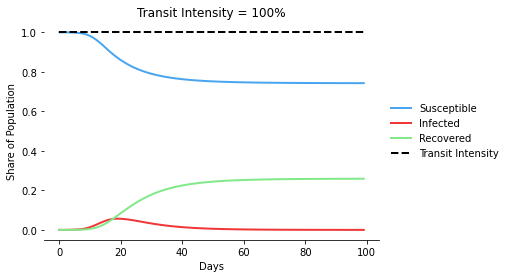

In [178]:
# constant transit at 1
ptv = generate_ptv(public_trans=1, days=100, scenario=1)
plot_title = 'Transit_Intensity_=_100%'
args1 = parser.parse_args(f'--gamma 0.2 --public-trans-vec {ptv} --plot-title {plot_title}'.split())
covid_sim(args1)

Initial Infected: 290
Infected on March 1st: 0
Total Infected: 0.122


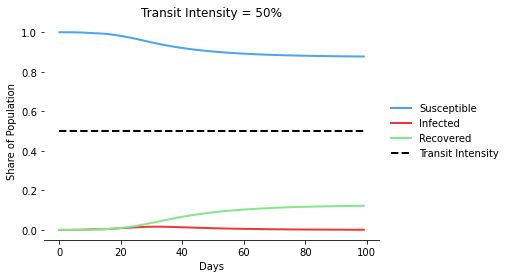

In [179]:
# constant transit at 0.50
ptv = generate_ptv(public_trans=0.50, days=100, scenario=1)
plot_title = 'Transit_Intensity_=_50%'
args1 = parser.parse_args(f'--public-trans-vec {ptv} --public-trans 0.50 --plot-title {plot_title}'.split())
covid_sim(args1)

Initial Infected: 290
Infected on March 1st: 0
Total Infected: 0.0035


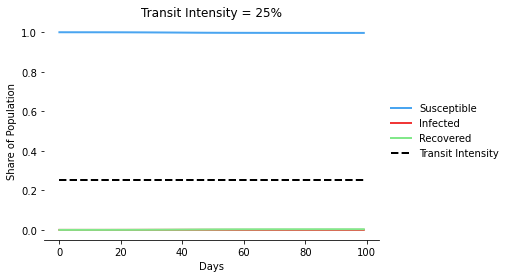

In [180]:
# constant transit at 0.25
ptv = generate_ptv(public_trans=0.25, days=100, scenario=1)
plot_title = 'Transit_Intensity_=_25%'
args1 = parser.parse_args(f'--public-trans 0.25 --public-trans-vec {ptv} --plot-title {plot_title}'.split())
covid_sim(args1)

## Experiment 2: travel decreases to different levels

Initial Infected: 290
Infected on March 1st: 0
Total Infected: 0.2218


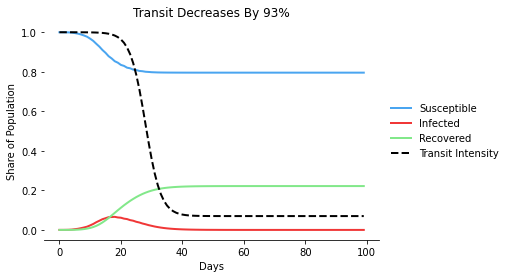

In [158]:
# transit decreases by 93%
plot_title = 'Transit_Decreases_By_93%'
ptv = gen_log_ptv(start_ptv=1)
args2 = parser.parse_args(f'--public-trans-vec {ptv} --plot-title {plot_title}'.split())
covid_sim(args2)

Initial Infected: 290
Infected on March 1st: 0
Total Infected: 0.2193


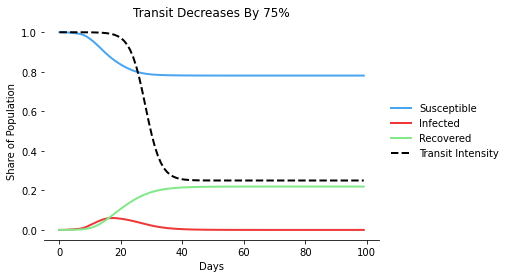

In [159]:
# transit decreases By 75%
plot_title = 'Transit_Decreases_By_75%'
ptv = gen_log_ptv(min_ptv=0.25)
args2 = parser.parse_args(f'--beta .75 --public-trans-vec {ptv} --plot-title {plot_title}'.split())
covid_sim(args2)

Initial Infected: 290
Infected on March 1st: 0
Total Infected: 0.2341


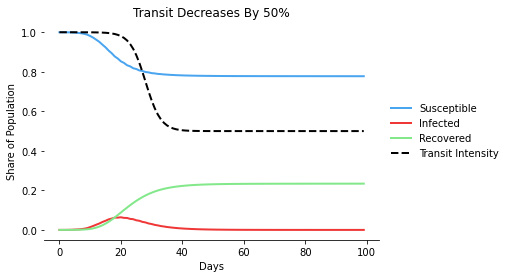

In [173]:
# transit decreases By 50%
plot_title = 'Transit_Decreases_By_50%'
ptv = gen_log_ptv(min_ptv=0.5)
args2 = parser.parse_args(f'--beta .75 --public-trans-vec {ptv} --plot-title {plot_title}'.split())
covid_sim(args2)

## Experiment 3: Tuning $\beta$

Initial Infected: 290
Infected on March 1st: 0
Total Infected: 0.4017


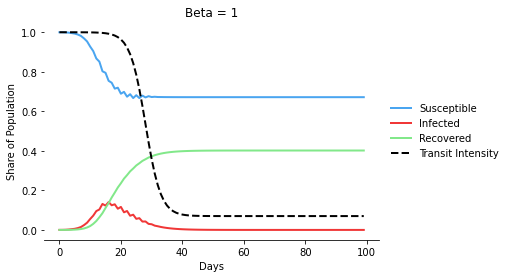

In [174]:
# Beta 1
plot_title = 'Beta_=_1'
ptv = gen_log_ptv()
args3 = parser.parse_args(f'--beta 1 --public-trans-vec {ptv} --plot-title {plot_title}'.split())
covid_sim(args3)

Initial Infected: 290
Infected on March 1st: 0
Total Infected: 0.109


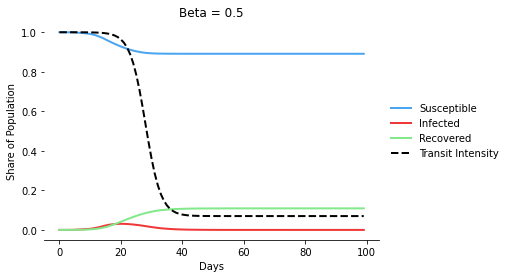

In [175]:
# Beta .5
plot_title = 'Beta_=_0.5'
ptv = gen_log_ptv()
args3 = parser.parse_args(f'--beta 0.5 --public-trans-vec {ptv} --plot-title {plot_title}'.split())
covid_sim(args3)

Initial Infected: 290
Infected on March 1st: 0
Total Infected: 0.2232


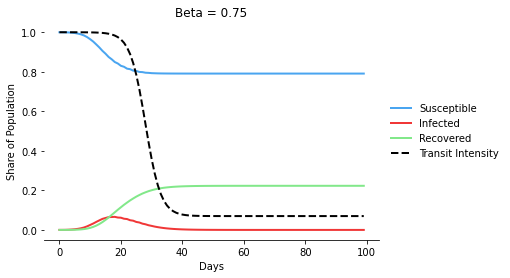

In [176]:
# Beta .75
plot_title = 'Beta_=_0.75'
ptv = gen_log_ptv()
args3 = parser.parse_args(f'--beta 0.75 --public-trans-vec {ptv} --plot-title {plot_title}'.split())
covid_sim(args3)

Initial Infected: 290
Total Infected: 0.2357


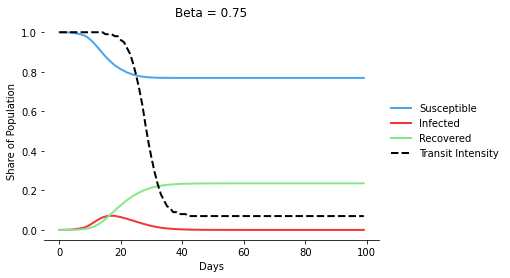

In [8]:
plot_title = 'Beta_=_0.75'
args3 = parser.parse_args(f'--beta 0.75 --plot-title {plot_title}'.split())
covid_sim(args3)

## Experiment 4: effect of government reaction time

Initial Infected: 290
Infected on March 1st: 0
Total Infected: 0.1496


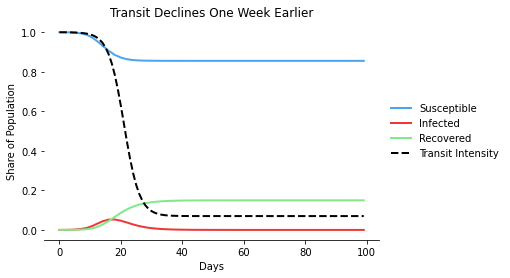

In [168]:
# Limiting travel begins one week earlier
plot_title = 'Transit_Declines_One_Week_Earlier'
ptv = gen_log_ptv(inflection=21)
args4 = parser.parse_args(f'--public-trans-vec {ptv} --plot-title {plot_title}'.split())
covid_sim(args4)

Initial Infected: 290
Infected on March 1st: 0
Total Infected: 0.2192


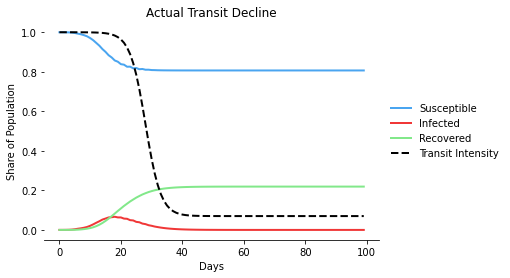

In [171]:
# Actual transit decline
plot_title = 'Actual_Transit_Decline'
ptv = gen_log_ptv()
args4 = parser.parse_args(f'--public-trans-vec {ptv} --plot-title {plot_title}'.split())
covid_sim(args4)

Initial Infected: 290
Infected on March 1st: 0
Total Infected: 0.2408


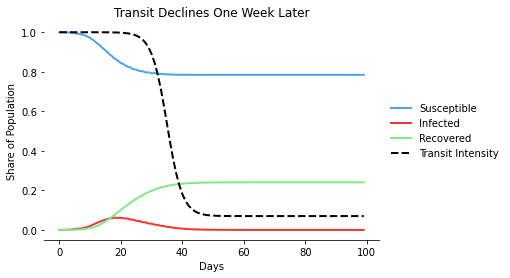

In [170]:
# Limiting travel begins one week earlier
plot_title = 'Transit_Declines_One_Week_Later'
ptv = gen_log_ptv(inflection=35)
args4 = parser.parse_args(f'--public-trans-vec {ptv} --plot-title {plot_title}'.split())
covid_sim(args4)

## Experiment 5: restrictions are lifted on May 15th and transit level increases 

Initial Infected: 290
Infected on March 1st: 0
Total Infected: 0.0802


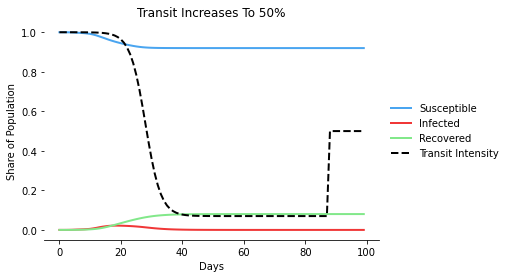

In [164]:
# NYC reopens, transit goes to 50%
plot_title = 'Transit_Increases_To_50%'
ptv = gen_log_ptv(reopen=True, reopen_val=0.5)
args3 = parser.parse_args(f'--public-trans-vec {ptv} --plot-title {plot_title}'.split())
covid_sim(args3)

Initial Infected: 290
Infected on March 1st: 0
Total Infected: 0.08


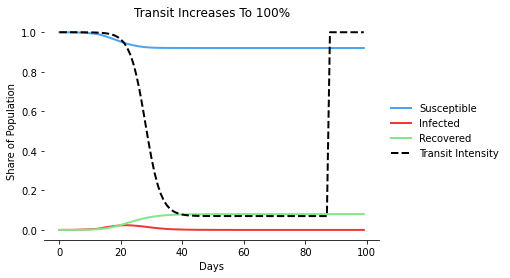

In [165]:
# NYC reopens, transit goes to 100%
plot_title = 'Transit_Increases_To_100%'
ptv = gen_log_ptv(reopen=True, reopen_val=1)
args3 = parser.parse_args(f'--public-trans-vec {ptv} --plot-title {plot_title}'.split())
covid_sim(args3)

Initial Infected: 290
Infected on March 1st: 0
Total Infected: 0.0931


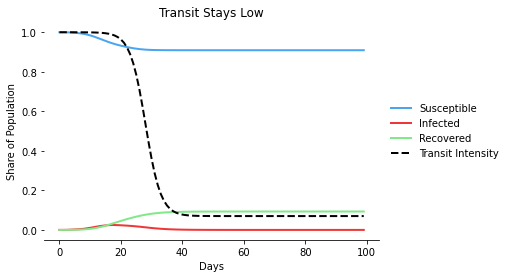

In [166]:
# Transit Stays Low
plot_title = 'Transit_Stays_Low'
ptv = gen_log_ptv()
args3 = parser.parse_args(f'--public-trans-vec {ptv} --plot-title {plot_title}'.split())
covid_sim(args3)

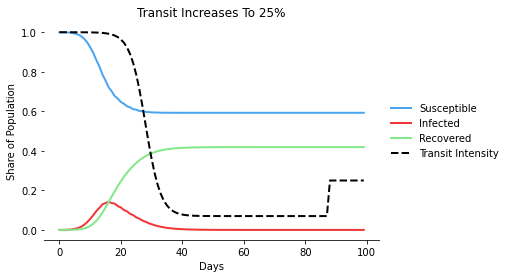

In [115]:
# NYC reopens, transit goes to 25%
plot_title = 'Transit_Increases_To_25%'
ptv = gen_log_ptv(reopen=True, reopen_val=.25)
args3 = parser.parse_args(f'--public-trans-vec {ptv} --plot-title {plot_title}'.split())
covid_sim(args3)

## Experiment 6: Testing Starting Infections

Text(0.5, 1.0, 'Population Distribtion By Zone')

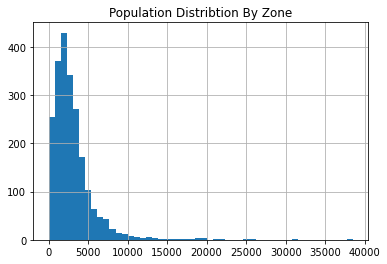

In [198]:
# Visualizing distribution of population amongs tracts
OD = pd.read_csv('data/nyc_od.csv', header=None, dtype=np.float64).to_numpy()


# initialize the population vector from the origin-destination flow matrix
N_k = np.abs(np.diagonal(OD) + OD.sum(axis=0) - OD.sum(axis=1))
pop_series = pd.Series(N_k)
pop_series.hist(bins=50)
plt.title('Population Distribtion By Zone')

Initial Infected: 65
Infected on March 1st: 0
Total Infected: 0.2144


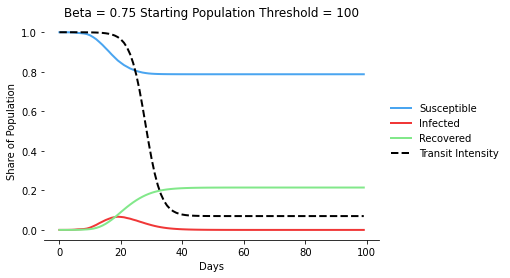

In [149]:
# Beta .75, Start with 5% of people infected from zones with under 100 people only
plot_title = 'Beta_=_0.75_Starting_Population_Threshold_=_100'
ptv = gen_log_ptv()
args3 = parser.parse_args(f'--thresh2 100 --public-trans-vec {ptv} --plot-title {plot_title}'.split())
covid_sim(args3)

Initial Infected: 0
Infected on March 1st: 0
Total Infected: 0.0


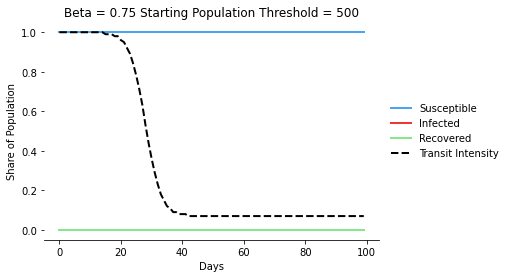

In [199]:
# Beta .75, Start with 5% of people infected from zones with under 500 people only
plot_title = 'Beta_=_0.75_Starting_Population_Threshold_=_500'
ptv = gen_log_ptv()
args3 = parser.parse_args(f'--thresh2 500 --infect-pct 0.0 --public-trans-vec {ptv} --plot-title {plot_title}'.split())
covid_sim(args3)